In [1]:
# Import necessary libraries
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("YelpUserAnalysis") \
    .getOrCreate()

24/11/24 19:18:34 WARN Utils: Your hostname, yelp resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s17)
24/11/24 19:18:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/24 19:18:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/11/24 19:18:40 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
yelp_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_business.json")

24/11/24 20:13:09 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [3]:
yelp_df.printSchema()
yelp_df.show(5)

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [4]:
users_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_user.json")

In [5]:
arizona_df = yelp_df.filter(yelp_df["state"] == "AZ")
arizona_df.show(10)

+--------------------+--------------------+--------------------+--------------------+----------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|      city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+----------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|5255 E Broadway Blvd|{null, null, null...|tUFrWirKiKi_TAnsV...|Department Stores...|    Tucson|{8:0-23:0, 8:0-22...|      0| 32.223236| -110.880452|              Target|      85711|          22|  3.5|   AZ|
|     625 N Stone Ave|{null, null, null...|rBmpy_Y1UbBx8ggHl...|Automotive, Auto ...|    Tucson|{8:0-17:0, 0:0-0:...|      1|32.2298719|-110.9723419|Arizona Truck Out..

In [6]:
arizona_df.createOrReplaceTempView("arizona_df")

In [7]:
arizona_df.write.parquet("file:///home/dps/Documents/temp/arizona_businesses_filtered_project2.parquet")
yelp_df.select("categories").distinct().show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------+
|categories                                                                                                                   |
+-----------------------------------------------------------------------------------------------------------------------------+
|Arts & Entertainment, Event Planning & Services, Venues & Event Spaces, Museums                                              |
|Food, Convenience Stores, Restaurants, Food Delivery Services, Local Flavor, Delis                                           |
|Automotive, Auto Repair, Towing, Body Shops, Oil Change Stations, Auto Parts & Supplies, Tires                               |
|Makeup Artists, Hair Salons, Beauty & Spas                                                                                   |
|Breweries, American (New), Restaurants, Burgers, American (Traditional), Gastropubs, Brewpubs, Food, Fi

In [12]:
reviews_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_review.json")

In [14]:
# Filter for businesses in the chosen category (e.g., Restaurants)
category_reviews_df = reviews_df.join(arizona_df, reviews_df.business_id == arizona_df.business_id) \
                                .filter(arizona_df["categories"].contains("Breweries"))

category_reviews_df.show(5)


+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+------+--------------------+-------+-------------+---------------+--------------------+-----------+------------+-----+-----+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|             address|          attributes|         business_id|          categories|  city|               hours|is_open|     latitude|      longitude|                name|postal_code|review_count|stars|state|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+------+--------------------+-------+-------------+---------------+--------------------+-----------+------------

In [15]:
# Join reviews with user data
user_reviews_df = category_reviews_df.join(users_df, category_reviews_df.user_id == users_df.user_id)

# Display the first few rows
user_reviews_df.show(5)



+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+------+--------------------+-------+-------------+---------------+--------------------+-----------+------------+-----+-----+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-----+----+-------+-----+-----+------------+------+--------------------+-------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|             address|          attributes|         business_id|          categories|  city|               hours|is_open|     latitude|      longitude|                name|postal_code|review_count|stars|state|average_stars|compliment_cool|

In [19]:
# Alias the DataFrames to avoid ambiguity
reviews_df = reviews_df.alias("reviews")
users_df = users_df.alias("users")

# Join reviews with user data, specifying the columns explicitly to avoid ambiguity
user_reviews_df = reviews_df.join(users_df, reviews_df["user_id"] == users_df["user_id"], "inner") \
    .select(reviews_df["user_id"], users_df["name"], reviews_df["text"], reviews_df["business_id"], users_df["review_count"])

# Show the first few rows to verify
user_reviews_df.show(5)

+--------------------+----+--------------------+--------------------+------------+
|             user_id|name|                text|         business_id|review_count|
+--------------------+----+--------------------+--------------------+------------+
|--6lqYpHZCBbpW5z2...|Jeff|Honestly was only...|mUI4DJagyUyu76qnR...|           9|
|--Kwhcbkh7jxkhVVQ...|Larz|The place is abso...|ORL4JE6tz3rJxVqkd...|          58|
|--Kwhcbkh7jxkhVVQ...|Larz|Ate dinner there ...|tIvfmgT1qMeAEQf8C...|          58|
|--Kwhcbkh7jxkhVVQ...|Larz|It was okay. If y...|Ld805G25xHALqbBo1...|          58|
|--Kwhcbkh7jxkhVVQ...|Larz|Went for a nice l...|arQfMJal1tl67Z96R...|          58|
+--------------------+----+--------------------+--------------------+------------+
only showing top 5 rows



In [27]:
users_df.createOrReplaceTempView("users_df")

In [21]:
reviews_df.createOrReplaceTempView("reviews")

In [16]:
spark.sql("""
    SELECT name AS brewery_name, city, state
    FROM arizona_df
    WHERE categories LIKE '%Breweries%'
""").show()

+--------------------+----------+-----+
|        brewery_name|      city|state|
+--------------------+----------+-----+
|   Blackrock Brewers|    Tucson|   AZ|
|      Barrio Brewing|    Tucson|   AZ|
|Dove Mountain Bre...|    Marana|   AZ|
|Harbottle Brewing...|    Tucson|   AZ|
|   Firetruck Brewing|Oro Valley|   AZ|
|Ten Fifty-Five Br...|    Tucson|   AZ|
|   Firetruck Brewing|    Tucson|   AZ|
|      TapHouse Grill|    Tucson|   AZ|
|Ten55 Brewing Com...|    Tucson|   AZ|
|  Green Feet Brewing|    Tucson|   AZ|
|Dillinger Brewing...|    Tucson|   AZ|
|      Nimbus Brewing|    Tucson|   AZ|
|   Firetruck Brewing|    Tucson|   AZ|
|     Serial Grillers|    Tucson|   AZ|
|Dillinger Brewing...|    Tucson|   AZ|
|Catalina Brewing ...|    Tucson|   AZ|
|1912 Brewing Company|    Tucson|   AZ|
|   Button Brew House|    Tucson|   AZ|
| Jalopy's Grillville|    Tucson|   AZ|
|Thunder Canyon Br...|    Tucson|   AZ|
+--------------------+----------+-----+
only showing top 20 rows



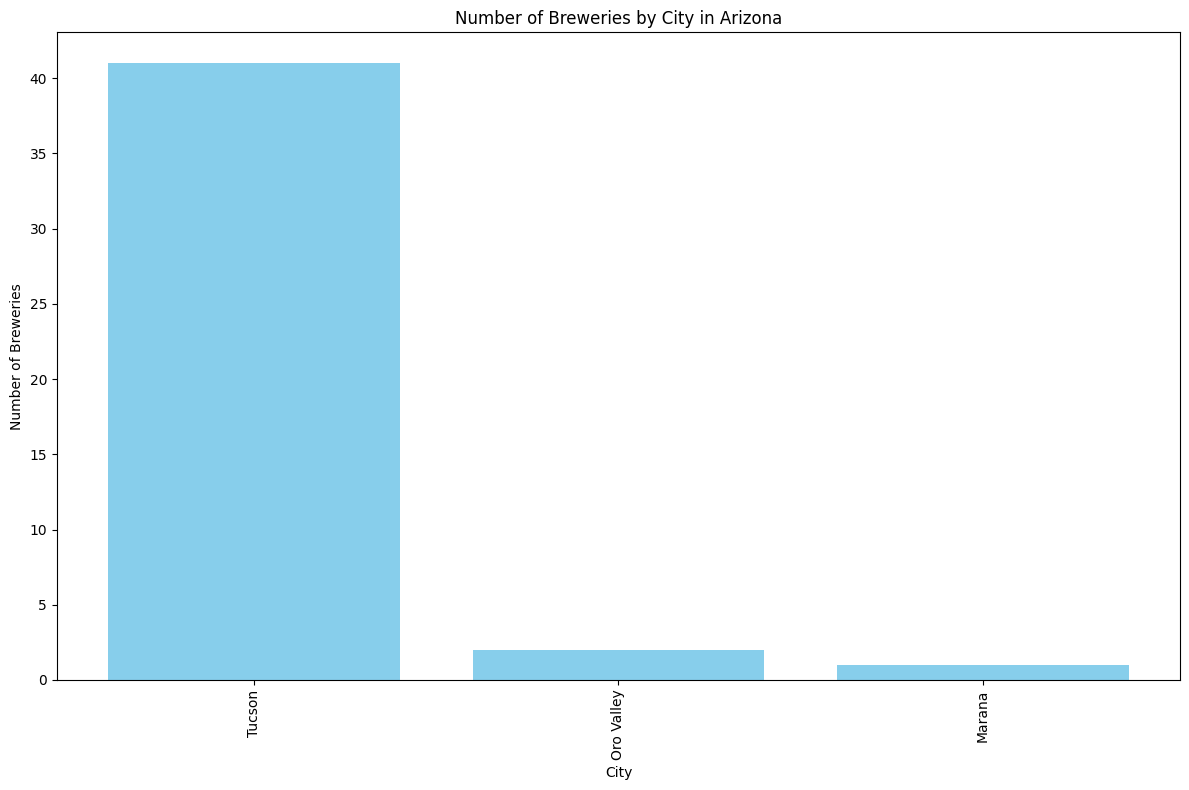

In [17]:
import matplotlib.pyplot as plt
import pandas as pd


result = spark.sql("""
    SELECT city, COUNT(*) AS num_breweries
    FROM arizona_df
    WHERE categories LIKE '%Breweries%'
    GROUP BY city
    ORDER BY num_breweries DESC
""")


arizona_breweries = result.toPandas()


plt.figure(figsize=(12, 8))


plt.bar(arizona_breweries['city'], arizona_breweries['num_breweries'], color='skyblue')


plt.xlabel('City')
plt.ylabel('Number of Breweries')
plt.title('Number of Breweries by City in Arizona')
plt.xticks(rotation=90) 


plt.tight_layout()
plt.show()


In [18]:
spark.sql("""
    SELECT city, AVG(stars) AS avg_rating
    FROM arizona_df
    WHERE categories LIKE '%Breweries%'
    GROUP BY city
    ORDER BY avg_rating DESC
""").show()


+----------+------------------+
|      city|        avg_rating|
+----------+------------------+
|    Tucson|3.8536585365853657|
|Oro Valley|              3.75|
|    Marana|               3.0|
+----------+------------------+



In [ ]:
result = spark.sql("""
    WITH brewery_ratings AS (
        SELECT ab.city, ab.name AS brewery_name, AVG(r.stars) AS avg_rating
        FROM arizona_df ab
        JOIN reviews r ON ab.business_id = r.business_id
        WHERE ab.categories LIKE '%Breweries%'
        GROUP BY ab.city, ab.name
    )
    SELECT city, brewery_name, avg_rating
    FROM brewery_ratings
    WHERE avg_rating > 4
    ORDER BY avg_rating DESC
""").show(10)



+------+--------------------+------------------+
|  city|        brewery_name|        avg_rating|
+------+--------------------+------------------+
|Tucson|   Blackrock Brewers| 4.472222222222222|
|Tucson|Ten Fifty-Five Br...| 4.645833333333333|
|Tucson|Harbottle Brewing...| 4.714285714285714|
|Tucson|      Barrio Brewing| 4.046104928457869|
|Tucson|Dillinger Brewing...| 4.449275362318841|
|Tucson|Ten55 Brewing Com...| 4.040983606557377|
|Tucson|  Green Feet Brewing| 4.521739130434782|
|Tucson|Catalina Brewing ...| 4.154929577464789|
|Tucson|     Serial Grillers| 4.328780487804878|
|Tucson|   Button Brew House|4.4393939393939394|
+------+--------------------+------------------+
only showing top 10 rows



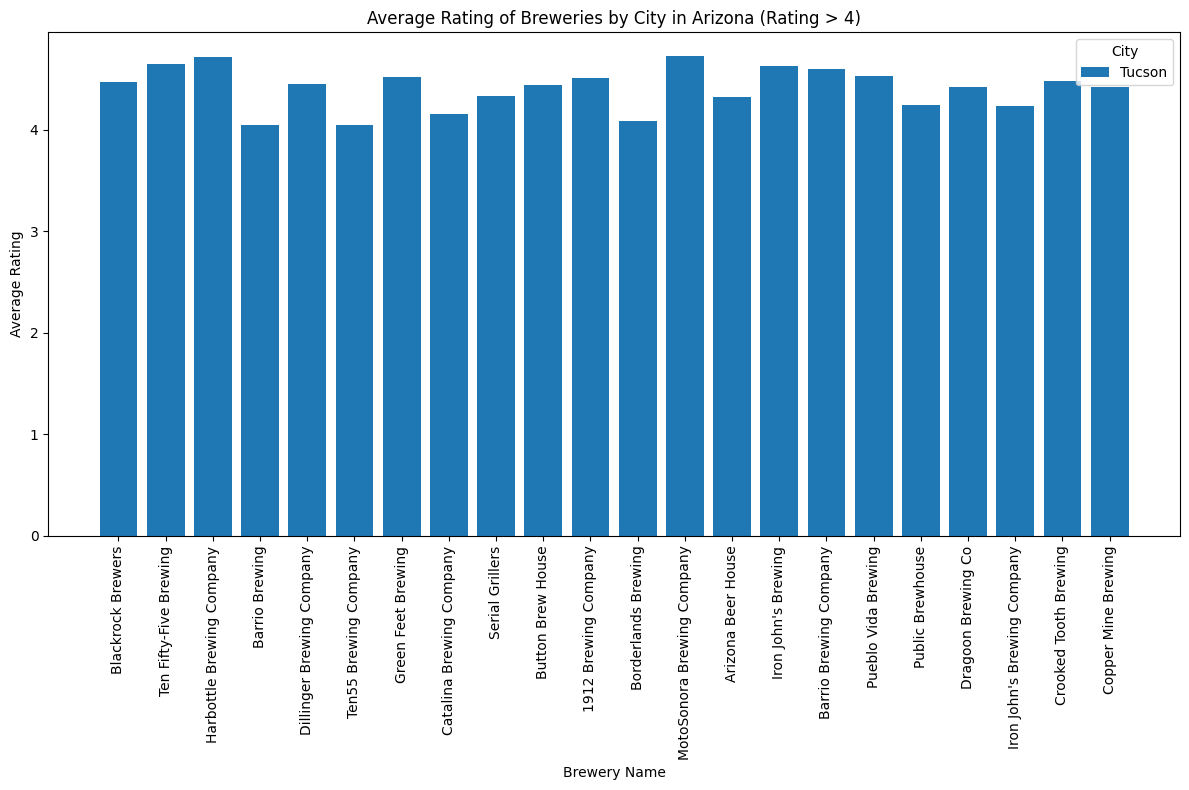

In [24]:
import matplotlib.pyplot as plt
import pandas as pd


result = spark.sql("""
    SELECT ab.city, ab.name AS brewery_name, AVG(r.stars) AS avg_rating
    FROM arizona_df ab
    JOIN reviews r ON ab.business_id = r.business_id
    WHERE ab.categories LIKE '%Breweries%'
    GROUP BY ab.city, ab.name
    HAVING AVG(r.stars) > 4
""")


arizona_pandas = result.toPandas()


plt.figure(figsize=(12, 8))


for city in arizona_pandas['city'].unique():
    
    city_data = arizona_pandas[arizona_pandas['city'] == city]
    plt.bar(city_data['brewery_name'], city_data['avg_rating'], label=city)


plt.xlabel('Brewery Name')
plt.ylabel('Average Rating')
plt.title('Average Rating of Breweries by City in Arizona (Rating > 4)')
plt.xticks(rotation=90) 
plt.legend(title='City')


plt.tight_layout()
plt.show()


In [28]:
spark.sql("""
    SELECT u.user_id, AVG(r.stars) AS avg_review_stars
    FROM reviews r
    JOIN users_df u ON r.user_id = u.user_id
    JOIN arizona_df ab ON r.business_id = ab.business_id
    WHERE ab.categories LIKE '%Breweries%'
    GROUP BY u.user_id
    ORDER BY avg_review_stars DESC
    LIMIT 5
""").show()


24/11/24 20:48:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:48:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:48:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:48:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+--------------------+----------------+
|             user_id|avg_review_stars|
+--------------------+----------------+
|-Wrb1uyUNXp6XZsdE...|             5.0|
|-PNOT-APcKKu9PFok...|             5.0|
|-P7QbuJKBALJYH2_c...|             5.0|
|-pN5Er7tJQon7XhPl...|             5.0|
|GXx1Gz2bJn-UrBbpx...|             5.0|
+--------------------+----------------+



In [29]:
spark.sql("""
    SELECT ab.name AS brewery_name, COUNT(r.review_id) AS num_reviews
    FROM reviews r
    JOIN arizona_df ab ON r.business_id = ab.business_id
    WHERE ab.categories LIKE '%Breweries%'
    GROUP BY ab.name
    ORDER BY num_reviews DESC
""").show()


+--------------------+-----------+
|        brewery_name|num_reviews|
+--------------------+-----------+
|     Serial Grillers|       1025|
|BJ's Restaurant &...|        678|
|      Barrio Brewing|        629|
|Thunder Canyon Br...|        579|
|Gentle Ben’s Brewery|        371|
|                1702|        351|
|Sentinel Peak Bre...|        329|
| Zpizza - Oro Valley|        256|
|         Old Chicago|        237|
| Borderlands Brewing|        220|
|Dove Mountain Bre...|        199|
|  Dragoon Brewing Co|        192|
| Pueblo Vida Brewing|        184|
|      Nimbus Brewing|        167|
|  Arizona Beer House|        167|
|Crooked Tooth Bre...|        166|
|       Nimbus Bistro|        129|
|Ten55 Brewing Com...|        122|
|   Firetruck Brewing|         95|
|1912 Brewing Company|         91|
+--------------------+-----------+
only showing top 20 rows



In [31]:
spark.sql("""
    SELECT 
        ab.city, 
        ab.name AS brewery_name,
        COUNT(r.review_id) AS num_reviews,
        AVG(r.stars) AS avg_rating,
        COUNT(CASE WHEN r.stars >= 4 THEN 1 END) AS high_rated_reviews
    FROM arizona_df ab
    JOIN reviews r ON ab.business_id = r.business_id
    JOIN users_df u ON r.user_id = u.user_id
    WHERE ab.categories LIKE '%Breweries%'
    GROUP BY ab.city, ab.name
    HAVING AVG(r.stars) > 4 AND COUNT(r.review_id) > 50
    ORDER BY num_reviews DESC
""").show()


+------+--------------------+-----------+------------------+------------------+
|  city|        brewery_name|num_reviews|        avg_rating|high_rated_reviews|
+------+--------------------+-----------+------------------+------------------+
|Tucson|     Serial Grillers|       1025| 4.328780487804878|               853|
|Tucson|      Barrio Brewing|        629| 4.046104928457869|               492|
|Tucson| Borderlands Brewing|        220| 4.081818181818182|               173|
|Tucson|  Dragoon Brewing Co|        192| 4.416666666666667|               167|
|Tucson| Pueblo Vida Brewing|        184|4.5271739130434785|               168|
|Tucson|  Arizona Beer House|        167| 4.323353293413174|               141|
|Tucson|Crooked Tooth Bre...|        166| 4.481927710843373|               148|
|Tucson|Ten55 Brewing Com...|        122| 4.040983606557377|                89|
|Tucson|1912 Brewing Company|         91|4.5054945054945055|                78|
|Tucson|Catalina Brewing ...|         71

In [33]:
spark.sql("""
    SELECT 
        ab.name AS brewery_name,
        ab.city AS city,
        AVG(r.stars) AS avg_rating,
        COUNT(r.review_id) AS review_count,
        CASE 
            WHEN AVG(r.stars) >= 4.5 THEN 'Excellent'
            WHEN AVG(r.stars) >= 3.5 THEN 'Good'
            WHEN AVG(r.stars) >= 2.5 THEN 'Average'
            ELSE 'Below Average'
        END AS rating_category
    FROM arizona_df ab
    JOIN reviews r ON ab.business_id = r.business_id
    WHERE ab.categories LIKE '%Breweries%'
    AND ab.city = 'Tucson'
    GROUP BY ab.name, ab.city
    HAVING COUNT(r.review_id) > 5
    ORDER BY avg_rating DESC, review_count DESC
""").show(10)



+--------------------+------+------------------+------------+---------------+
|        brewery_name|  city|        avg_rating|review_count|rating_category|
+--------------------+------+------------------+------------+---------------+
|MotoSonora Brewin...|Tucson|  4.72093023255814|          43|      Excellent|
|Harbottle Brewing...|Tucson| 4.714285714285714|          35|      Excellent|
|Ten Fifty-Five Br...|Tucson| 4.645833333333333|          48|      Excellent|
| Iron John's Brewing|Tucson|  4.62962962962963|          54|      Excellent|
| Pueblo Vida Brewing|Tucson|4.5271739130434785|         184|      Excellent|
|  Green Feet Brewing|Tucson| 4.521739130434782|          23|      Excellent|
|1912 Brewing Company|Tucson|4.5054945054945055|          91|      Excellent|
|Crooked Tooth Bre...|Tucson| 4.481927710843373|         166|           Good|
|   Blackrock Brewers|Tucson| 4.472222222222222|          36|           Good|
|Dillinger Brewing...|Tucson| 4.449275362318841|          69|   

                  user_id  distinct_breweries_reviewed
0  s_JDz1gBlk8nDgwiFj9_cA                           25
1  c8FmQwkyL3MizFPCSUfaaw                           19
2  lHqA_D7nAK9xw_Xg08dM_w                           18
3  qjuaM8Cab0nwJ-zaOnzqgQ                           15
4  x2dkFstjm-FmOOoIUArOwg                           15


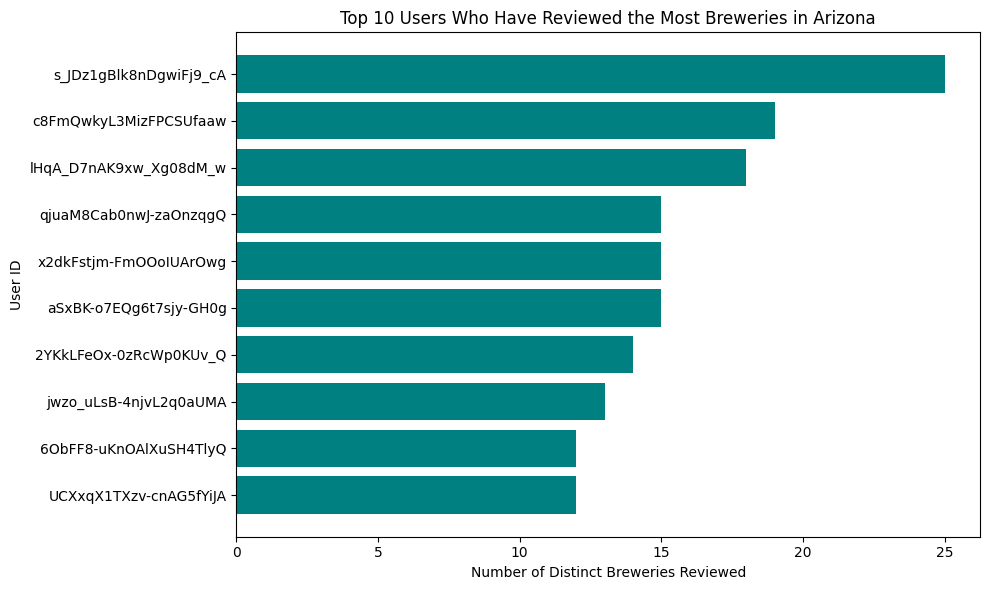

In [47]:
result = spark.sql("""
    SELECT 
        r.user_id, 
        COUNT(DISTINCT r.business_id) AS distinct_breweries_reviewed
    FROM reviews r
    JOIN arizona_df ab ON r.business_id = ab.business_id
    WHERE ab.categories LIKE '%Breweries%'
    AND ab.state = 'AZ'  -- Focused on Arizona breweries
    GROUP BY r.user_id
    ORDER BY distinct_breweries_reviewed DESC
    LIMIT 10
""").toPandas()


print(result.head())


import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.barh(result['user_id'].astype(str), result['distinct_breweries_reviewed'], color='teal')


plt.title('Top 10 Users Who Have Reviewed the Most Breweries in Arizona')
plt.xlabel('Number of Distinct Breweries Reviewed')
plt.ylabel('User ID')


plt.gca().invert_yaxis()


plt.tight_layout()
plt.show()
